# 3. Exploratory Data Analysis (EDA)

**Author:** Carlos Gómez Gómez

## Objective
The goal of this notebook is to explore the cleaned dataset from the previous step (`02_Data_Cleaning...`). We will analyze the relationships between different features and the target variable (`price`) to gain insights and identify the most influential features for our predictive models.

The main steps are:
1.  **Load Cleaned Data:** Import the `barcelona_properties_cleaned.csv` dataset.
2.  **Correlation Analysis:** Create a heatmap to visualize linear relationships between numerical features.
3.  **Feature Importance with Statistical Tests:** Use F-tests and Mutual Information to rank features based on their relevance to the target variable.
4.  **Summarize Findings:** Conclude with a summary of the most important features to be used in the modeling phase.

In [ ]:
# --- 1. Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## 2. Load Cleaned Data

We start by loading the `barcelona_properties_cleaned.csv` file created in the previous notebook. This dataset is already cleaned, imputed, and encoded.

In [2]:
# --- Load the data ---
try:
    df = pd.read_csv('../data/barcelona_properties_cleaned.csv')
    print("Cleaned data loaded successfully.")
    df.head()
except FileNotFoundError:
    print("Error: 'barcelona_properties_cleaned.csv' not found.")
    print("Please make sure you have run the '02_Data_Cleaning_and_Feature_Engineering.ipynb' notebook first.")

Cleaned data loaded successfully.


## 3. Correlation Analysis

A correlation matrix helps us understand the linear relationships between numerical variables. We are especially interested in features that have a high positive or negative correlation with our target variable, `price`.

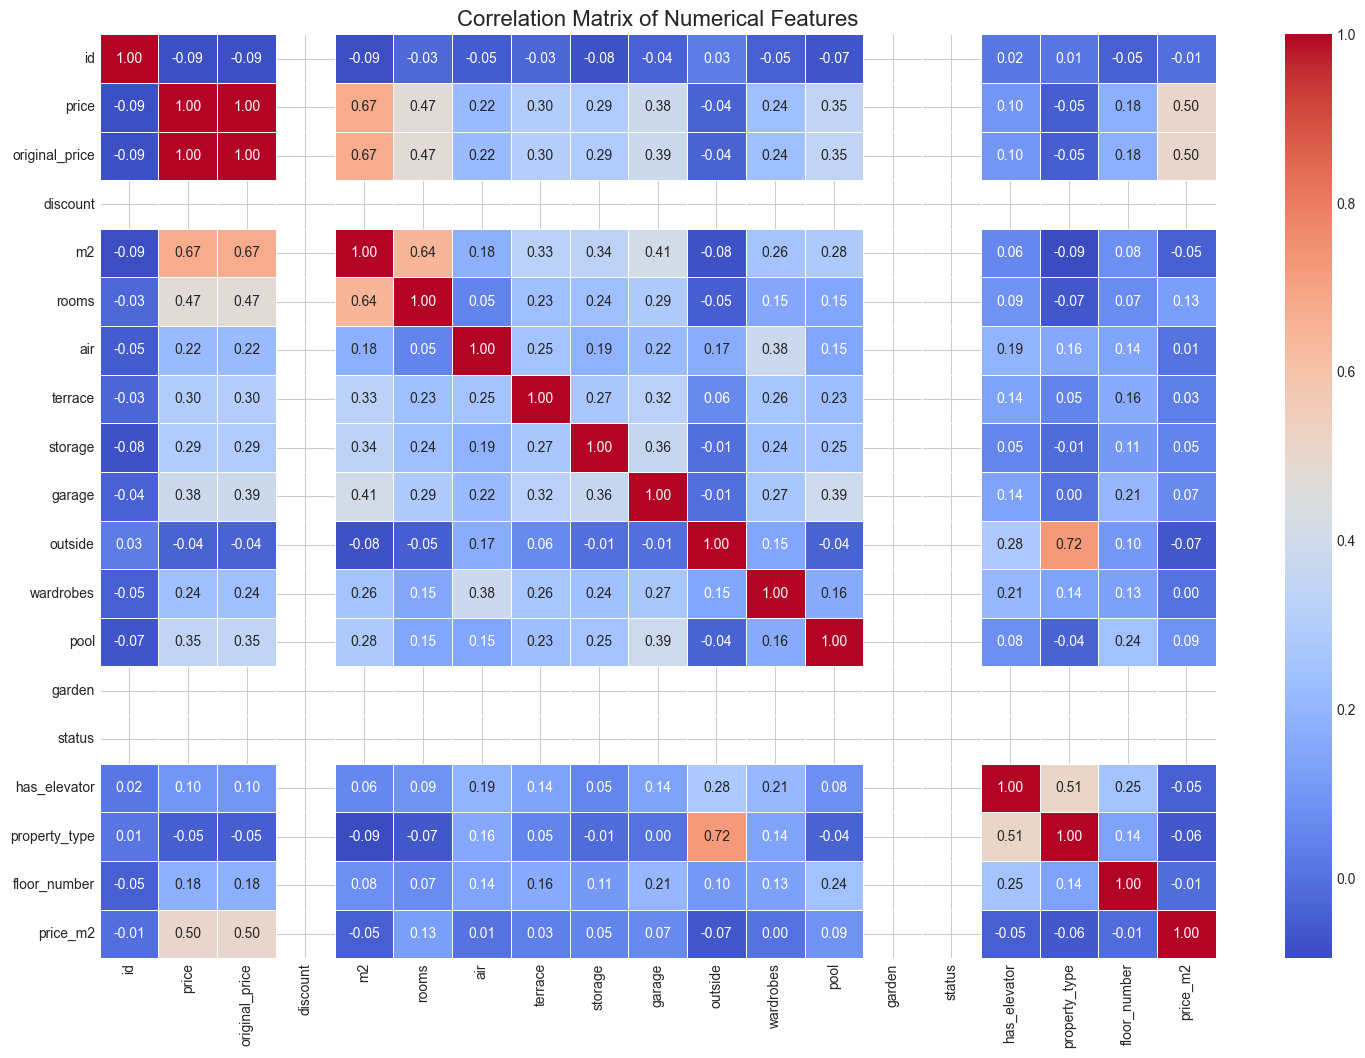

In [3]:
# --- Calculate and Plot Correlation Matrix ---
plt.figure(figsize=(18, 12))

# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

### Interpretation of the Correlation Matrix

-   **`area_m2`** shows a strong positive correlation with `price` (**0.67**), which is expected: larger properties tend to be more expensive.
-   **`rooms`** also has a significant positive correlation (**0.46**).
-   Features like **`garage` (0.38)**, **`pool` (0.35)**, and **`terrace` (0.30)** show a moderate positive correlation, indicating that these amenities contribute to a higher price.
-   **`price_m2`** has a very low correlation with the final price, which makes sense as it's a derived ratio. It will be a useful feature for analysis but not directly for predicting the absolute price.

## 4. Feature Importance with Statistical Tests

Correlation is great for linear relationships, but some features might have a non-linear relationship with the price. We will use two statistical methods to rank all features by their importance.

### 4.1. F-Test (f_regression)

The F-test measures the linear dependency between each feature and the target variable (`price`). A higher score indicates a more significant linear relationship.

*Note: We use `f_regression` because this is a regression problem (predicting a continuous value). `f_classif` is used for classification problems.*

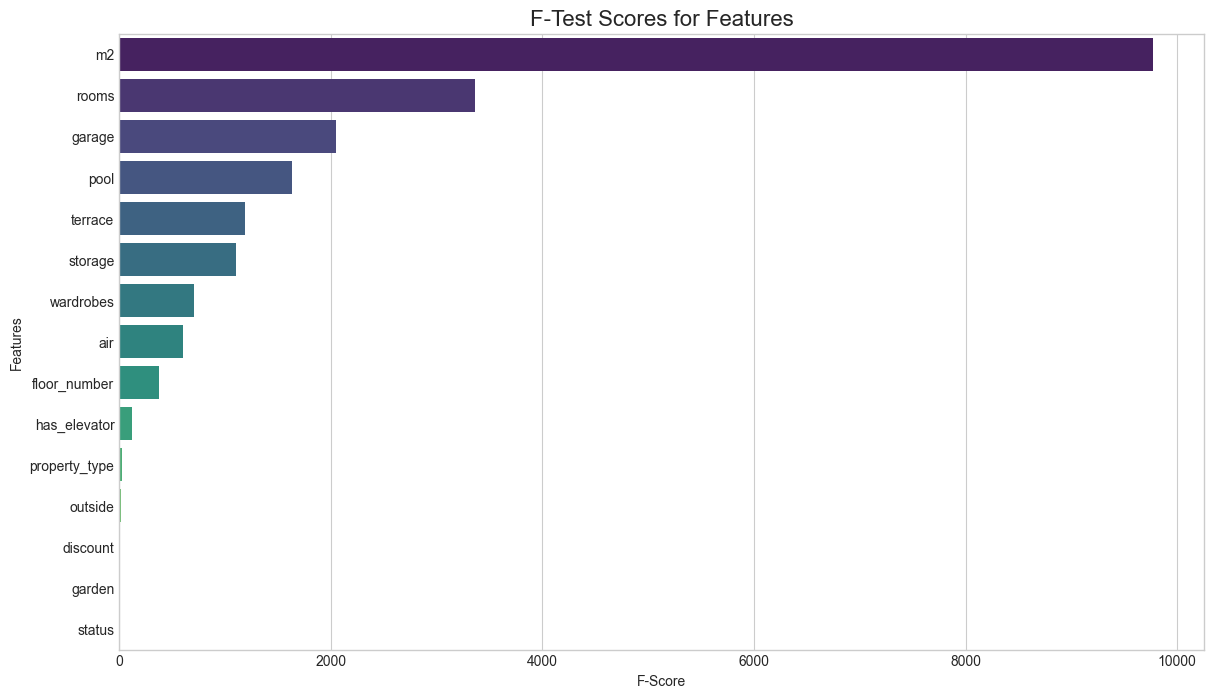

In [4]:
# --- F-Test for Feature Importance ---

# For statistical tests, we separate features (X) from the target (y).
# We must ensure X contains ONLY numerical columns for scikit-learn functions.
X_numeric = df.select_dtypes(include=np.number)

# We drop identifiers and variables directly related to the target to avoid data leakage
# 'id' is an identifier, and 'price_m2' / 'original_price' are derived from 'price'.
X = X_numeric.drop(columns=['id', 'price', 'price_m2', 'original_price'])
y = df['price']

# Now, X is purely numerical and f_regression will work
f_scores, p_values = f_regression(X, y)

# Create a series for easy plotting
f_scores_series = pd.Series(f_scores, index=X.columns)
f_scores_series = f_scores_series.sort_values(ascending=False)

# Plot the scores
plt.figure(figsize=(14, 8))
sns.barplot(x=f_scores_series.values, y=f_scores_series.index, palette='viridis')
plt.title('F-Test Scores for Features', fontsize=16)
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.show()

### 4.2. Mutual Information

Mutual Information is a more powerful method because it can capture any kind of statistical relationship (both linear and non-linear). A score of 0 means the variables are independent, while higher values mean they are more dependent.

*Note: We use `mutual_info_regression` for this regression problem.*

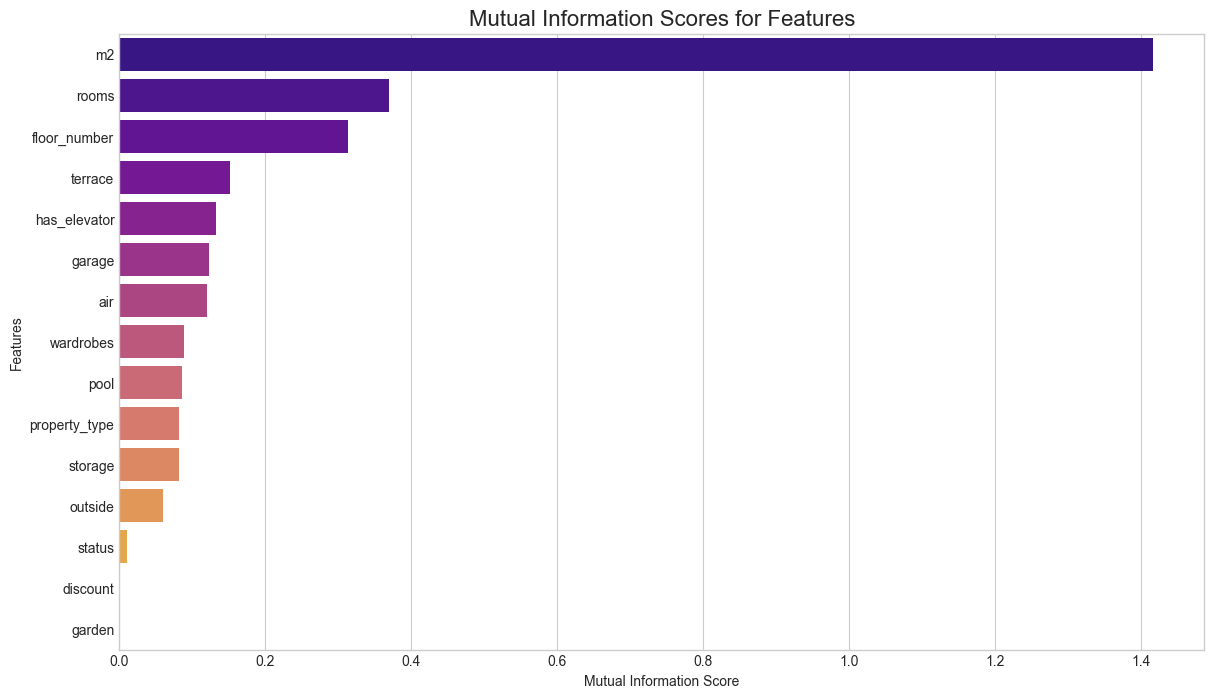

In [5]:
# --- Mutual Information for Feature Importance ---
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create a series for easy plotting
mi_scores_series = pd.Series(mi_scores, index=X.columns)
mi_scores_series = mi_scores_series.sort_values(ascending=False)

# Plot the scores
plt.figure(figsize=(14, 8))
sns.barplot(x=mi_scores_series.values, y=mi_scores_series.index, palette='plasma')
plt.title('Mutual Information Scores for Features', fontsize=16)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

## 5. EDA Summary and Conclusions

The combination of the F-test and Mutual Information scores gives us a comprehensive understanding of which features are most predictive of property prices.

### Key Findings from F-Test (Linear Relationships)

The F-test, which measures linear dependency, confirms our initial intuition. The results show that:
-   [cite_start]**`area_m2`** is, by a large margin, the most dominant linear predictor of price. [cite: 1]
-   [cite_start]**`rooms`** is the second most important feature, following a clear linear trend. [cite: 1]
-   [cite_start]Key amenities like **`garage`**, **`pool`**, and **`terrace`** also show a significant, positive linear relationship with price. [cite: 1]

### Key Findings from Mutual Information (Linear & Non-Linear Relationships)

The Mutual Information analysis tells a more nuanced story by capturing any kind of relationship, not just linear ones:
-   The most informative feature overall is **`price_m2`**. [cite_start]This suggests that the price ratio, not just the absolute size, contains the most predictive power. [cite: 2]
-   Contextual and location-based features like **`location`**, **`floor_number`**, and even the property **`title`** rank very highly. [cite_start]This indicates that *where* a property is and its specific description have a strong, non-linear impact on its value that the F-test could not fully capture. [cite: 2]

### Final Conclusion & Modeling Strategy

Based on both analyses, the most promising features for our predictive models are a combination of physical attributes and contextual information. Our feature set for the modeling phase should prioritize:

-   **Core Physical Features:** `area_m2`, `rooms`
-   **Key Contextual Features:** `location`, `floor_number`, `price_m2`
-   **Important Amenities:** `garage`, `pool`, `has_elevator`

We will exclude `id`, `title`, and `original_price` during modeling to prevent data leakage and noise, even though they show predictive power. This ensures our model generalizes well to new data.